In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 1.0
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 100

## Black-Scholes model with latent Markov volatility
The model starts with a flat volatility at $\sigma_0$ which can jump once to a different value $\sigma_1$ with intensity $\lambda$. 

The call price in this model is (assuming no interest rate/T-forward measure):

$$
E[(X_T-K)_+] = E[E[BS(\sigma^2T= \sigma_0^2 \tau + \sigma_1^2 (T-\tau) ) 1_{\tau<T} + BS(\sigma^2T= \sigma_0^2 T ) 1_{\tau>=T}| \tau]]
$$

The conditional expectation is valued using the classical Black-Scholes formula with a volatility dependent on $\tau$; then the outer expectation is computed semi-analytically using the fact that $\tau$ follows an exponential distribution of parameter $\lambda$.

Compared to the usual Black-Scholes model, the hidden variable creates a volatility smile.


In [4]:
f = 100.0
sigma_0 = 20*ONE_PCT
sigma_1 = 40*ONE_PCT
lambda_ = 0.5
K_lo = 80.0
K_hi = 120.0

In [5]:
Model_LN = BS_Markov_simple_LN(sigma_0=sigma_0,
                               sigma_1=sigma_1,
                               lambda_=lambda_,
                               f=f,
                               n_strikes=N_STRIKES,
                               K_lo=K_lo,
                               K_hi=K_hi,
                               strike_type='strike',
                              )

### Intuitively, the model produces option prices between the two bounds defined by Black-Scholes prices for $\sigma_0$ and $\sigma_1$

In [6]:
IV = Model_LN.IV

[
    IV.price_from_vol_LN(sigma_0, f, f, Model_LN.T_expiry),

    IV.price_from_vol_LN(sigma_1, f, f, Model_LN.T_expiry),
]

[7.965567455405804, 9.818549574094074, 15.851941887820608]

## Implied volatility smile

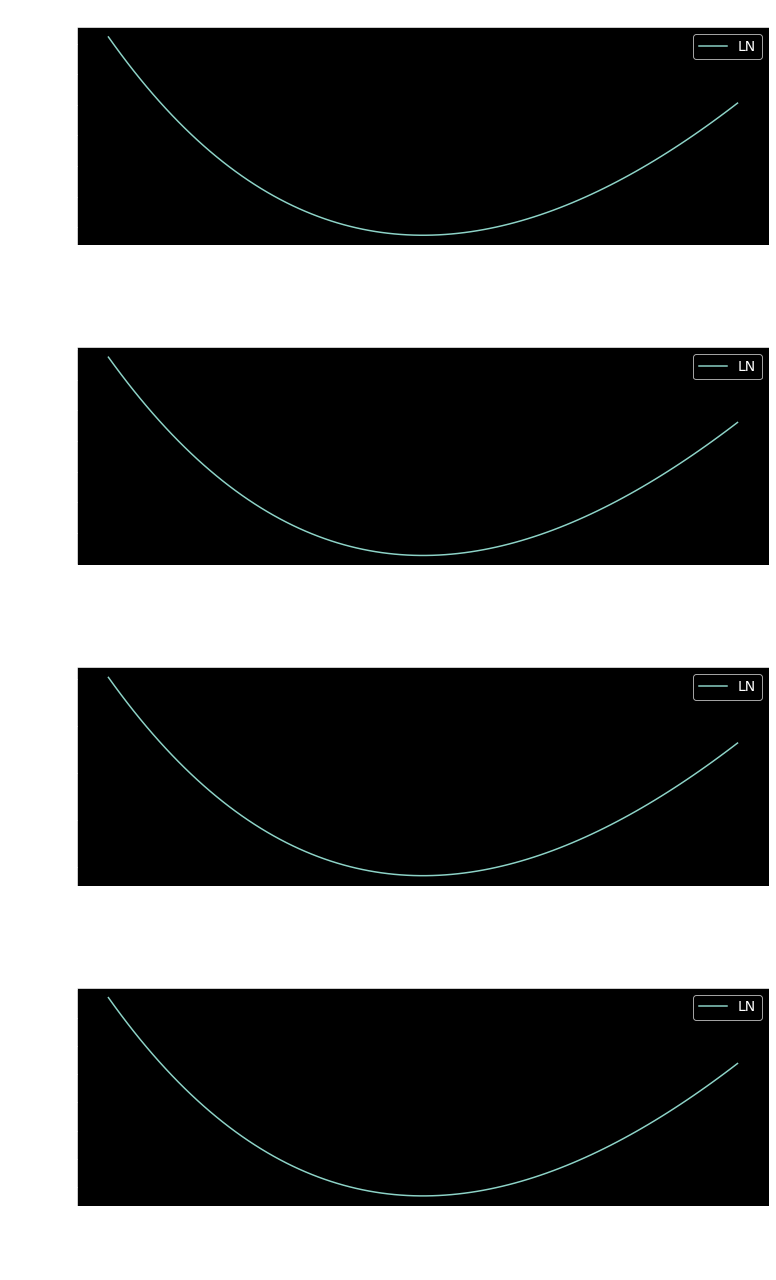

In [7]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

T_expiries = [1.0, 5.0, 10.0, 20.0]

fig, axes = plt.subplots(nrows=4, ncols=1)

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    x_grid = Model_LN.strike_grid

    smile = list(Model_LN.smile.values())
    ax.plot(x_grid, smile, label='LN')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.set_title('expiry={}y'.format(T_expiry))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

plt.tight_layout()
plt.show()

## Backbone i.e ATM vol move implied by forward move

Flat backbone : the model does not have any smile dynamics

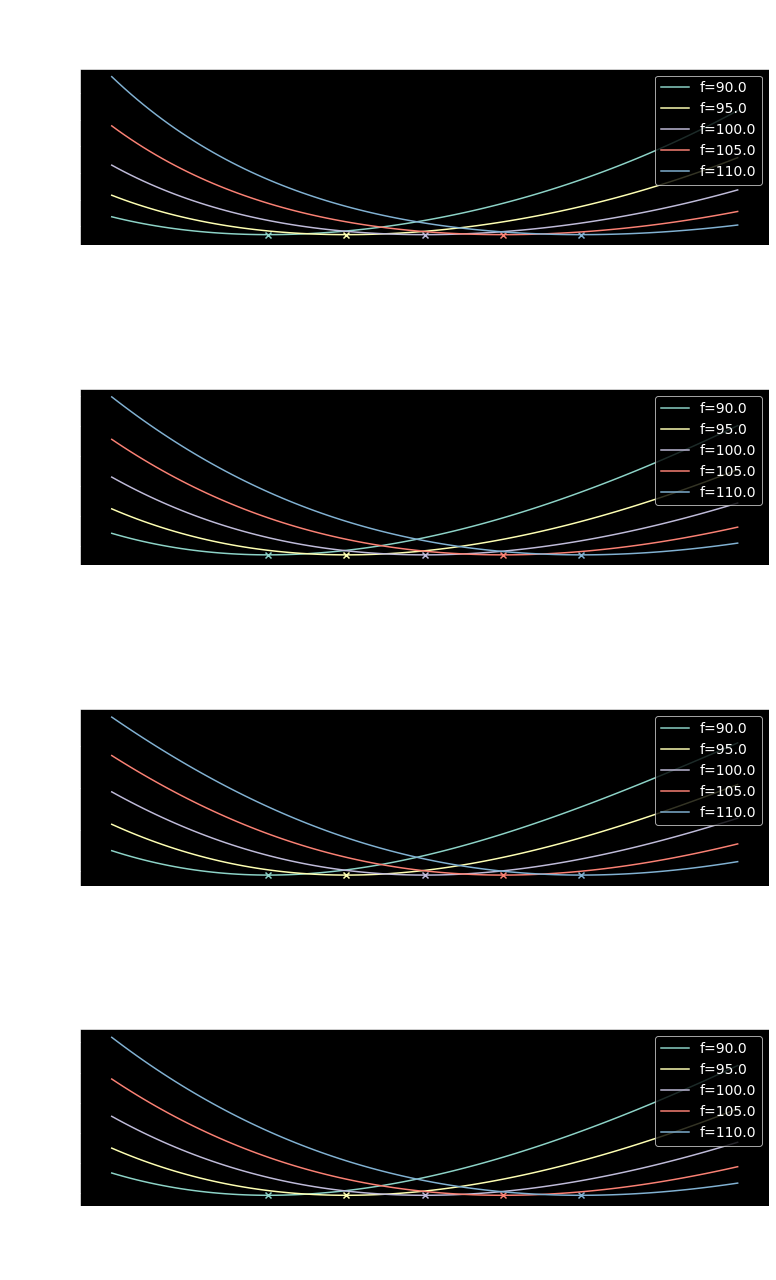

In [8]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 100.0

sigma_0 = 20*ONE_PCT
sigma_1 = 40*ONE_PCT
lambda_ = 0.5

lambdas_ = [
    0.1, 0.5, 2.0, 10.0,
]

f_shocks = [
    -10.0, 
    -5.0, 
    0.0, 
    5, 
    10,
]

Model_LN = BS_Markov_simple_LN(sigma_0=sigma_0,
                               sigma_1=sigma_1,
                               lambda_=lambda_,
                               f=f,
                               n_strikes=N_STRIKES,
                               K_lo=K_lo,
                               K_hi=K_hi,
                               strike_type='strike',
                              )
fig, axes = plt.subplots(nrows=4, ncols=1)
    
for i, ax in enumerate(axes):
    lambda_ = lambdas_[i]
    Model_LN.lambda_= lambda_
    for f_shock in f_shocks:
        Model_LN.f = f+f_shock
        smile = list(Model_LN.smile.values())
        label = 'f={}'.format(f+f_shock)
        ax.plot(Model_LN.strike_grid, smile, label=label)
        ax.scatter([Model_LN.f], [Model_LN.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
        ax.set_title('{}\n'.format(Model_LN.vol_type)\
                     +r'$\lambda$={}'.format(Model_LN.lambda_)+'\n'\
                    )

plt.tight_layout()
plt.show()

## Parameter sensitivities

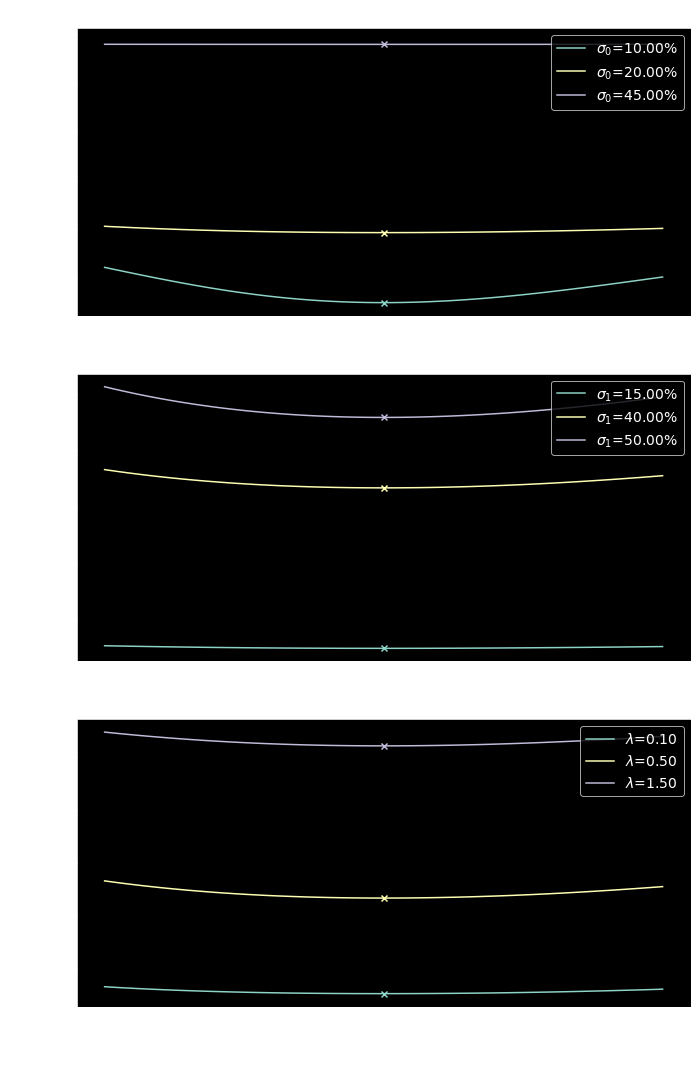

In [9]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 100.0

sigma_0 = 20*ONE_PCT
sigma_1 = 40*ONE_PCT
lambda_ = 0.5

sigma_0_shocks = [-0.1, 0.0, 0.25]
sigma_1_shocks = [-0.25, 0.0, 0.1]
lambda__shocks = [-0.4, 0.0, 1.0]

fig, axes = plt.subplots(nrows=3, ncols=1)

ax = axes[0]  
model = BS_Markov_simple_LN(sigma_0=sigma_0,
                            sigma_1=sigma_1,
                            lambda_=lambda_,
                            f=f,
                            n_strikes=N_STRIKES,
                            K_lo=K_lo,
                            K_hi=K_hi,
                            strike_type='strike',
                           )

for sigma_0_shock in sigma_0_shocks:
    model.sigma_0 = sigma_0+sigma_0_shock
    
    smile = list(model.smile.values())
    label = r'$\sigma_0$={:.2%}'.format(sigma_0+sigma_0_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$\sigma_0$ shock')

ax = axes[1]  
model = BS_Markov_simple_LN(sigma_0=sigma_0,
                            sigma_1=sigma_1,
                            lambda_=lambda_,
                            f=f,
                            n_strikes=N_STRIKES,
                            K_lo=K_lo,
                            K_hi=K_hi,
                            strike_type='strike',
                           )

for sigma_1_shock in sigma_1_shocks:
    model.sigma_1 = sigma_1+sigma_1_shock
    
    smile = list(model.smile.values())
    label = r'$\sigma_1$={:.2%}'.format(sigma_1+sigma_1_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$\sigma_1$ shock')

ax = axes[2]  
model = BS_Markov_simple_LN(sigma_0=sigma_0,
                            sigma_1=sigma_1,
                            lambda_=lambda_,
                            f=f,
                            n_strikes=N_STRIKES,
                            K_lo=K_lo,
                            K_hi=K_hi,
                            strike_type='strike',
                           )

for lambda__shock in lambda__shocks:
    model.lambda_ = lambda_+lambda__shock
    
    smile = list(model.smile.values())
    label = r'$\lambda$={:.2f}'.format(lambda_+lambda__shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$\lambda$ shock')